In [11]:
import numpy as np 
import gym
from gym import spaces

import numpy as np
import qutip as qt
import scipy as sci
import matplotlib.pyplot as plt

import stable_baselines
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO1, PPO2, TD3, A2C, SAC
from stable_baselines.deepq.policies import MlpPolicy as dqmlp
from stable_baselines.deepq.dqn import DQN

class GaussianEnv(gym.Env):
    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['console']}
    
    def __init__(self, min_sigma, max_sigma, max_amplitude, 
                 omega_0, init_state_array, num_timesteps):
        #The minimum variance for the gaussian distributions
        # Must be something > 0, to avoid a discountinuous control function
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma
        
        # Define maximum and minimum amplitudes for the Gaussians
        self.max_amplitude = max_amplitude
        
        self.num_timesteps = num_timesteps
        
        self.action_space = gym.spaces.Box(low=-1,high=1,shape=(4,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(4,4), dtype=np.float32)
        
        self.omega_0 = omega_0
        
        self.init_state_array = init_state_array
        self.num_timesteps = num_timesteps
        
        self.timestep_duration = (self.omega_0/40)/self.num_timesteps
        
    def reset(self):
        self.state = self.init_state_array
        self.done = False
        self.params_array = np.zeros((self.num_timesteps, 5))
        self.params_array[:,1], self.params_array[:,3] = 1,1
        self.timestep = 0
        self.populations = np.zeros((self.num_timesteps,3))
        return self.state.astype(np.float32)
    
    def control_function(self, t, amplitudes, mus, sigmas):
        """
        Defines a functions that uses a basis of gausssian functions to build other more complex functions
        """
        vals = amplitudes*np.exp(-0.5*((t - mus)/sigmas)**2)
        return np.sum(vals)
    
    
    def step(self, action):
        self.sigma_single_photon = ((action[0] + 1)/2)*self.max_sigma + self.min_sigma
        self.amplitude_single_photon = np.clip(self.max_amplitude*action[1],-10,10)
        
        self.sigma_two_photon = ((action[2] + 1)/2)*self.max_sigma + self.min_sigma
        self.amplitude_two_photon = np.clip(self.max_amplitude*action[3],-10,10)
        
        self.params_array[self.timestep,:] = np.array([ self.timestep*self.timestep_duration,
                                                        self.sigma_single_photon,
                                                        self.amplitude_single_photon,
                                                        self.sigma_two_photon,
                                                        self.amplitude_two_photon
                                                    ])
        
        def deltap(t, *args):
            x = self.omega_0*self.control_function(t, self.params_array[:,2], 
                                             self.params_array[:,0], 
                                                self.params_array[:,1])
            return x
        
        def delta2(t, *args):
            x = self.omega_0*self.control_function(t, self.params_array[:,4], 
                                             self.params_array[:,0], 
                                                self.params_array[:,3])
            return x
        gamma=0
        times = np.linspace(0,self.timestep_duration,5)
        coupling_h = (self.omega_0/2)*(qt.projection(4,1,0) + qt.projection(4,0,1)+
                                  qt.projection(4,2,1) + qt.projection(4,1,2))
        
        h_deltap = qt.projection(4,1,1)
        h_delta2 = qt.projection(4,2,2)
        collapse_op = np.sqrt(gamma)*qt.projection(4,3,1)
        input_state=qt.Qobj(self.state)
        results = qt.mesolve(H = [coupling_h, [h_deltap, deltap], [h_delta2, delta2]],
                            tlist = times, rho0= input_state, c_ops = collapse_op)
        self.state = results.states[-1].full()
        self.populations[self.timestep,:] = results.states[-1].diag()[:3]
        # A measure of performance between 0 and 1
        
        info={}
        
        self.timestep+=1
        reward = self.populations[-1,2]
       
        if self.timestep == self.num_timesteps:
            self.done = True
        done = self.done
        return self.state.astype(np.float32), reward, done, info

    def render(self, mode='console'):
        pass
    def close(self):
        pass

In [14]:

initial = np.zeros((4,4))
initial[0,0]=1


env = GaussianEnv(min_sigma=0.05, max_sigma=1, max_amplitude=10, omega_0=40,
                 init_state_array=initial, num_timesteps=10)
model = PPO1(policy=MlpPolicy, env=env, verbose=1, entcoeff=0.1, adam_epsilon=1e-3)

model.learn(total_timesteps=1000)



********** Iteration 0 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     7.69e-05 |      -0.56787 |       0.00885 |      4.34e-05 |       5.67870
     -0.00302 |      -0.56877 |       0.00681 |       0.00022 |       5.68768
     -0.00676 |      -0.56967 |       0.00637 |       0.00059 |       5.69665
     -0.01032 |      -0.57058 |       0.00516 |       0.00115 |       5.70581
Evaluating losses...
     -0.01331 |      -0.57114 |       0.00522 |       0.00161 |       5.71144
----------------------------------
| EpLenMean       | 10           |
| EpRewMean       | 0.0595       |
| EpThisIter      | 25           |
| EpisodesSoFar   | 25           |
| TimeElapsed     | 9.34         |
| TimestepsSoFar  | 256          |
| ev_tdlam_before | 0.15         |
| loss_ent        | 5.711441     |
| loss_kl         | 0.001605277  |
| loss_pol_entpen | -0.5711441   |
| loss_pol_surr   | -0.013306836 |
| loss_vf_loss    | 0.005223321  |
------

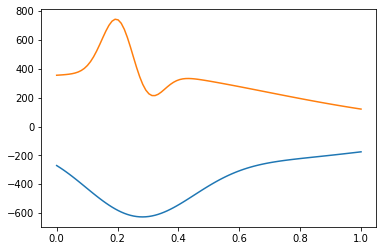

In [15]:
env.params_array

def func1(t, *args):
    x = env.omega_0*env.control_function(t, env.params_array[:,2],env.params_array[:,0], env.params_array[:,1])
    return x

def func2(t, *args):
    x = env.omega_0*env.control_function(t, env.params_array[:,4],env.params_array[:,0], env.params_array[:,3])
    return x



times = np.linspace(0, env.omega_0/40, 100)
plt.plot(times, [func1(t) for t in times])
plt.plot(times, [func2(t) for t in times])

In [16]:
times = np.linspace(0,env.omega_0/40,100)
coupling_h = (env.omega_0/2)*(qt.projection(3,1,0) + qt.projection(3,0,1)+
                          qt.projection(3,2,1) + qt.projection(3,1,2))

h_deltap = qt.projection(3,1,1)
h_delta2 = qt.projection(3,2,2)

init_state = qt.fock_dm(3,0,0)
results = qt.mesolve(H = [coupling_h, [h_deltap, func1], [h_delta2, func2]],
                    tlist = times, rho0= init_state)
populations =np.zeros((100,3))
for i in range(100):
    populations[i,:]= results.states[i].diag()[:]

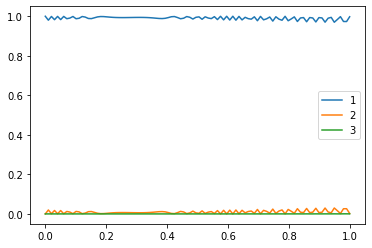

In [17]:
plt.plot(times, populations[:,0], label = "1")
plt.plot(times, populations[:,1], label = "2")
plt.plot(times, populations[:,2], label = "3")
plt.legend()

In [10]:
x = np.arange(4)

In [ ]:
np.concatenate((x, np.array([8])))

In [ ]:
qt.projection(4,3,1)